# Call Centre Performance & Debt-Recovery Effectiveness Analysis

# Business Problem
The organisation is experiencing inconsistent call-centre performance, leading to long handling times, low first-contact resolution, poor customer satisfaction, and inefficient use of staff. In addition, agents show varying ability to recover outstanding debt and negotiate realistic, sustainable payment plans, resulting in high rates of broken arrangements, repeat contact, and unresolved arrears.

 # Core Objectives
The primary goal is to transform raw operational data into actionable insights. The project aims to:
 *   **Improve Service Quality:** Reduce call times, increase first-contact resolution, and enhance overall customer satisfaction.
 *   **Boost Financial Performance:** Increase the effectiveness of debt recovery and design more sustainable payment plans to improve cash flow.
 *   **Enhance Operational Visibility:** Equip managers with data-driven tools to understand root causes, monitor agent performance, and implement targeted coaching.
 *   **Ensure Compliance:** Identify and support vulnerable customers effectively, ensuring adherence to regulatory standards.

 # Key Business Questions
 To achieve these objectives, the analysis will focus on answering the following:
 *   What operational factors drive long calls and repeat contact?
  * Which agent behaviours and negotiation styles correlate with successful outcomes?
 *   What customer or account characteristics predict successful debt repayment?
 *   Why are payment plans failing and how can their sustainability be improved?
 *   How can we optimise staffing, call routing, and agent coaching with data?

# Target Solution & Analytical Approach
The proposed solution is to develop a comprehensive analytics framework by:
 *   **Integrating Data:** Consolidate disparate data from telephony, CRM, collections, QA, and customer feedback systems into a single source of truth.
 *   **Building Predictive Models:** Create models to forecast the likelihood of successful debt repayment and identify accounts at high risk of repeat contact or default.
 *   **Developing Dashboards:** Design and deploy interactive dashboards for leadership. These tools will provide clear, real-time insights into performance drivers, enabling early intervention and effective agent coaching.

# Measures of Success
The success of this project will be measured by quantifiable improvements in:
 *   **Efficiency Metrics:** Reduction in Average Handle Time (AHT) and increase in First Contact Resolution (FCR).
 *   **Financial Metrics:** Increase in total debt recovered and a reduction in the rate of broken payment arrangements.
*   **Customer Metrics:** Improvement in Customer Satisfaction (CSAT) scores.

In [41]:

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import random

# Create folder
os.makedirs("data", exist_ok=True)

In [25]:
# Install necessary libraries
!pip install xgboost shap dash plotly


In [26]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import random

# Create folder
os.makedirs("data", exist_ok=True)

# -----------------------------
# 1. Generate CALLS dataset
# -----------------------------
n_calls = 2000
start_date = datetime(2024, 1, 1)

calls = pd.DataFrame({
    "call_id": range(1, n_calls + 1),
    "customer_id": np.random.randint(1000, 2000, n_calls),
    "agent_id": np.random.randint(1, 50, n_calls),
    "queue": np.random.choice(["Billing", "Tech", "Collections"], n_calls),
})

calls["call_start"] = [start_date + timedelta(minutes=random.randint(0, 60*24*60)) for _ in range(n_calls)]
calls["answer_time"] = calls["call_start"] + pd.to_timedelta(np.random.randint(5, 120, n_calls), unit="s")
calls["call_end"] = calls["answer_time"] + pd.to_timedelta(np.random.randint(60, 600, n_calls), unit="s")
calls["after_call_work_sec"] = np.random.randint(10, 120, n_calls)
calls["call_outcome"] = np.random.choice(["Completed", "Transferred", "Abandoned"], n_calls, p=[0.7, 0.2, 0.1])

calls.to_csv("data/calls.csv", index=False)

# -----------------------------
# 2. CRM dataset
# -----------------------------
crm = pd.DataFrame({
    "call_id": calls["call_id"],
    "case_id": np.random.randint(5000, 9000, n_calls),
    "case_type": np.random.choice(["Billing", "Complaint", "Tech", "General"], n_calls),
    "case_opened": calls["call_start"],
    "case_closed": calls["call_end"] + pd.to_timedelta(np.random.randint(0, 3, n_calls), unit="D"),
    "resolution_code": np.random.choice(["Resolved", "Escalated", "Pending"], n_calls)
})

crm.to_csv("data/crm.csv", index=False)

# -----------------------------
# 3. Collections dataset
# -----------------------------
n_accounts = 1200

collections = pd.DataFrame({
    "account_id": range(1, n_accounts + 1),
    "customer_id": np.random.randint(1000, 2000, n_accounts),
    "balance": np.random.randint(50, 2000, n_accounts),
    "due_date": [start_date - timedelta(days=random.randint(1, 120)) for _ in range(n_accounts)],
    "arrangement_start": [start_date - timedelta(days=random.randint(1, 60)) for _ in range(n_accounts)],
    "arrangement_end": [start_date + timedelta(days=random.randint(1, 60)) for _ in range(n_accounts)],
    "instalment_amount": np.random.randint(10, 200, n_accounts),
    "estimated_disposable_income": np.random.randint(50, 500, n_accounts),
    "arrangement_status": np.random.choice(["KEPT", "BROKEN", "ACTIVE"], n_accounts),
    "previous_arrangements": np.random.randint(0, 5, n_accounts)
})

collections.to_csv("data/collections.csv", index=False)

# -----------------------------
# 4. QA dataset
# -----------------------------
qa = pd.DataFrame({
    "call_id": calls["call_id"],
    "qa_score": np.random.randint(50, 100, n_calls),
    "compliance_pass": np.random.choice([0, 1], n_calls, p=[0.2, 0.8]),
    "notes": np.random.choice(["Good", "Needs improvement", "Excellent", "Average"], n_calls)
})

qa.to_csv("data/qa.csv", index=False)

# -----------------------------
# 5. CSAT dataset
# -----------------------------
csat = pd.DataFrame({
    "call_id": calls["call_id"],
    "csat_score": np.random.randint(1, 6, n_calls),
    "nps_category": np.random.choice(["Detractor", "Passive", "Promoter"], n_calls)
})

csat.to_csv("data/csat.csv", index=False)

print("Synthetic datasets created successfully!")


Synthetic datasets created successfully!


In [27]:
csat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   call_id       2000 non-null   int64 
 1   csat_score    2000 non-null   int64 
 2   nps_category  2000 non-null   object
dtypes: int64(2), object(1)
memory usage: 47.0+ KB


In [28]:
csat.isnull()

,call_id,csat_score,nps_category
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
1995,False,False,False
1996,False,False,False
1997,False,False,False
1998,False,False,False


In [29]:
csat.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
1995    False
1996    False
1997    False
1998    False
1999    False
Length: 2000, dtype: bool

In [30]:
# Force reload of modules to ensure latest code is used
import importlib
import src.data_extraction
import src.data_preparation
import src.feature_engineering
import src.modelling
import src.visualisation

importlib.reload(src.data_extraction)
importlib.reload(src.data_preparation)
importlib.reload(src.feature_engineering)
importlib.reload(src.modelling)
importlib.reload(src.visualisation)

# Import functions from the src module
from src.data_extraction import load_all
from src.data_preparation import prepare_calls, prepare_collections, join_datasets
from src.feature_engineering import (
    add_temporal_features,
    add_performance_flags,
    add_debt_features,
    build_modelling_dataset,
)
# CRITICAL FIX: Import the new training functions
from src.modelling import (
    train_arrangement_success_model,
    train_gradient_boosting_model,
    train_xgboost_model,
    explain_model_shap
)
from src.visualisation import plot_core_kpis, plot_debt_recovery, plot_agent_performance


In [31]:
# 1. Load Data
print("Loading data...")
calls_df, crm_df, coll_df, qa_df, csat_df = load_all()
print("Data loaded.")


Loading data...
Data loaded.


In [32]:
# Check for duplicates in all datasets
print("Duplicate Rows in Each Dataset:")
print("-" * 30)
print(f"Calls: {calls_df.duplicated().sum()}")
print(f"CRM: {crm_df.duplicated().sum()}")
print(f"Collections: {coll_df.duplicated().sum()}")
print(f"QA: {qa_df.duplicated().sum()}")
print(f"CSAT: {csat_df.duplicated().sum()}")


Duplicate Rows in Each Dataset:
------------------------------
Calls: 0
CRM: 0
Collections: 0
QA: 0
CSAT: 0


In [33]:
# 2. Prepare Data
print("Preparing data...")
calls_prepared = prepare_calls(calls_df)
coll_prepared = prepare_collections(coll_df)
df = join_datasets(calls_prepared, crm_df, coll_prepared, qa_df, csat_df)
print("Data prepared and joined.")


Preparing data...
Data prepared and joined.


In [34]:
# 3. Feature Engineering
print("Engineering features...")
df = add_temporal_features(df)
df = add_performance_flags(df)
df = add_debt_features(df)
print("Feature engineering complete.")


Engineering features...
Feature engineering complete.


### Data Quality, Completeness, and Accuracy Check
This section assesses the quality of the final dataset (`df`) before visualization and modeling.

--- 1. Completeness: Missing Values ---
                             missing_count  missing_percent
next_call_date                         866            43.30
days_to_next_call                      866            43.30
account_id                             621            31.05
balance                                621            31.05
due_date                               621            31.05
arrangement_start                      621            31.05
arrangement_end                        621            31.05
instalment_amount                      621            31.05
estimated_disposable_income            621            31.05
arrangement_status                     621            31.05
previous_arrangements                  621            31.05
days_past_due                          621            31.05
arrangement_length_days                621            31.05
arrangement_kept                       621            31.05
payment_plan_realism                   621            31.05


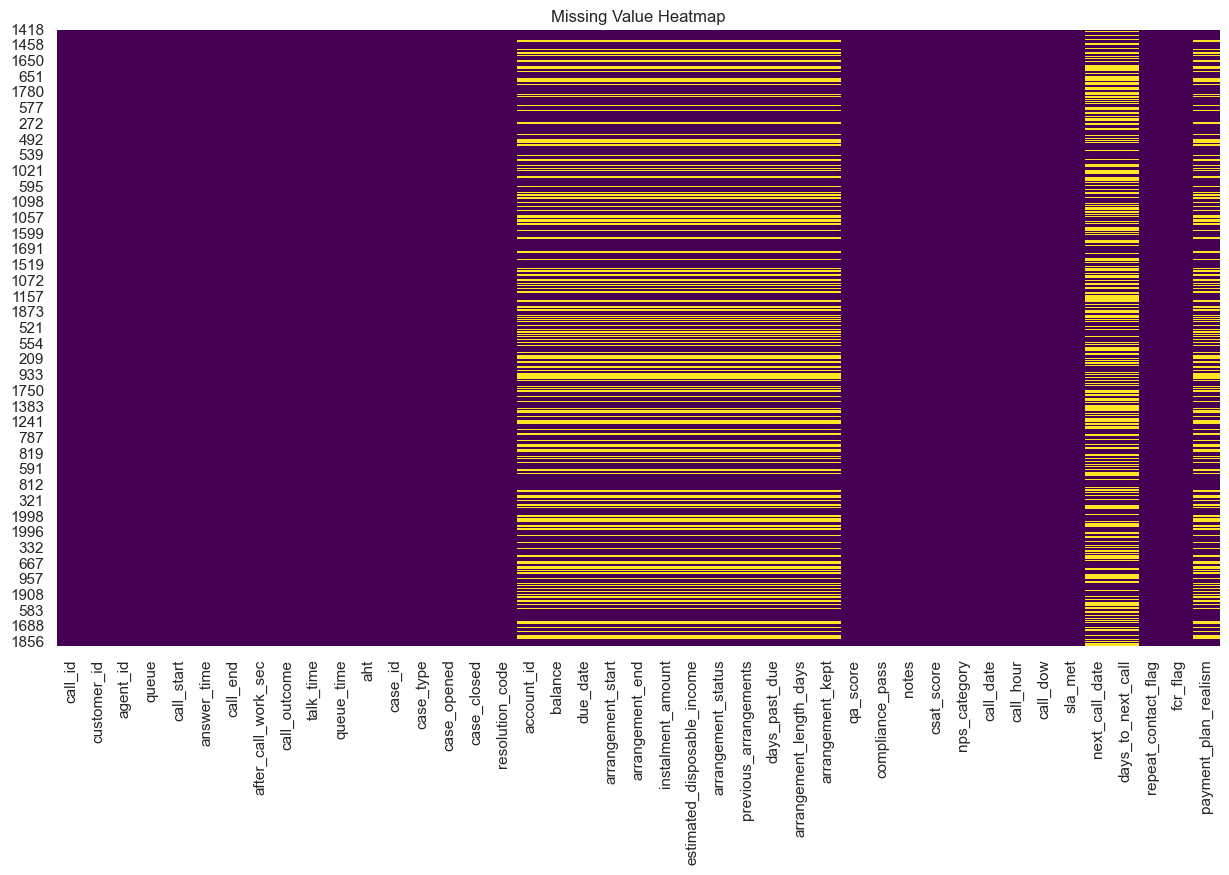


--- 2. Accuracy & Quality ---

Summary Statistics for Key Numerical Columns:
               aht    talk_time   queue_time      balance     qa_score  \
count  2000.000000  2000.000000  2000.000000  1379.000000  2000.000000   
mean    397.633500   332.659000    60.107500  1192.509065    74.790000   
std     157.202953   153.481778    32.825778   548.740265    14.607826   
min      74.000000    60.000000     5.000000    51.000000    50.000000   
25%     262.750000   200.000000    31.000000   737.500000    62.000000   
50%     400.000000   337.000000    60.000000  1260.000000    75.000000   
75%     528.250000   464.000000    88.000000  1676.000000    87.000000   
max     711.000000   599.000000   119.000000  1998.000000    99.000000   

       csat_score  
count  2000.00000  
mean      3.04600  
std       1.41488  
min       1.00000  
25%       2.00000  
50%       3.00000  
75%       4.00000  
max       5.00000  

Logical consistency checks passed (no negative durations).

Value Counts f

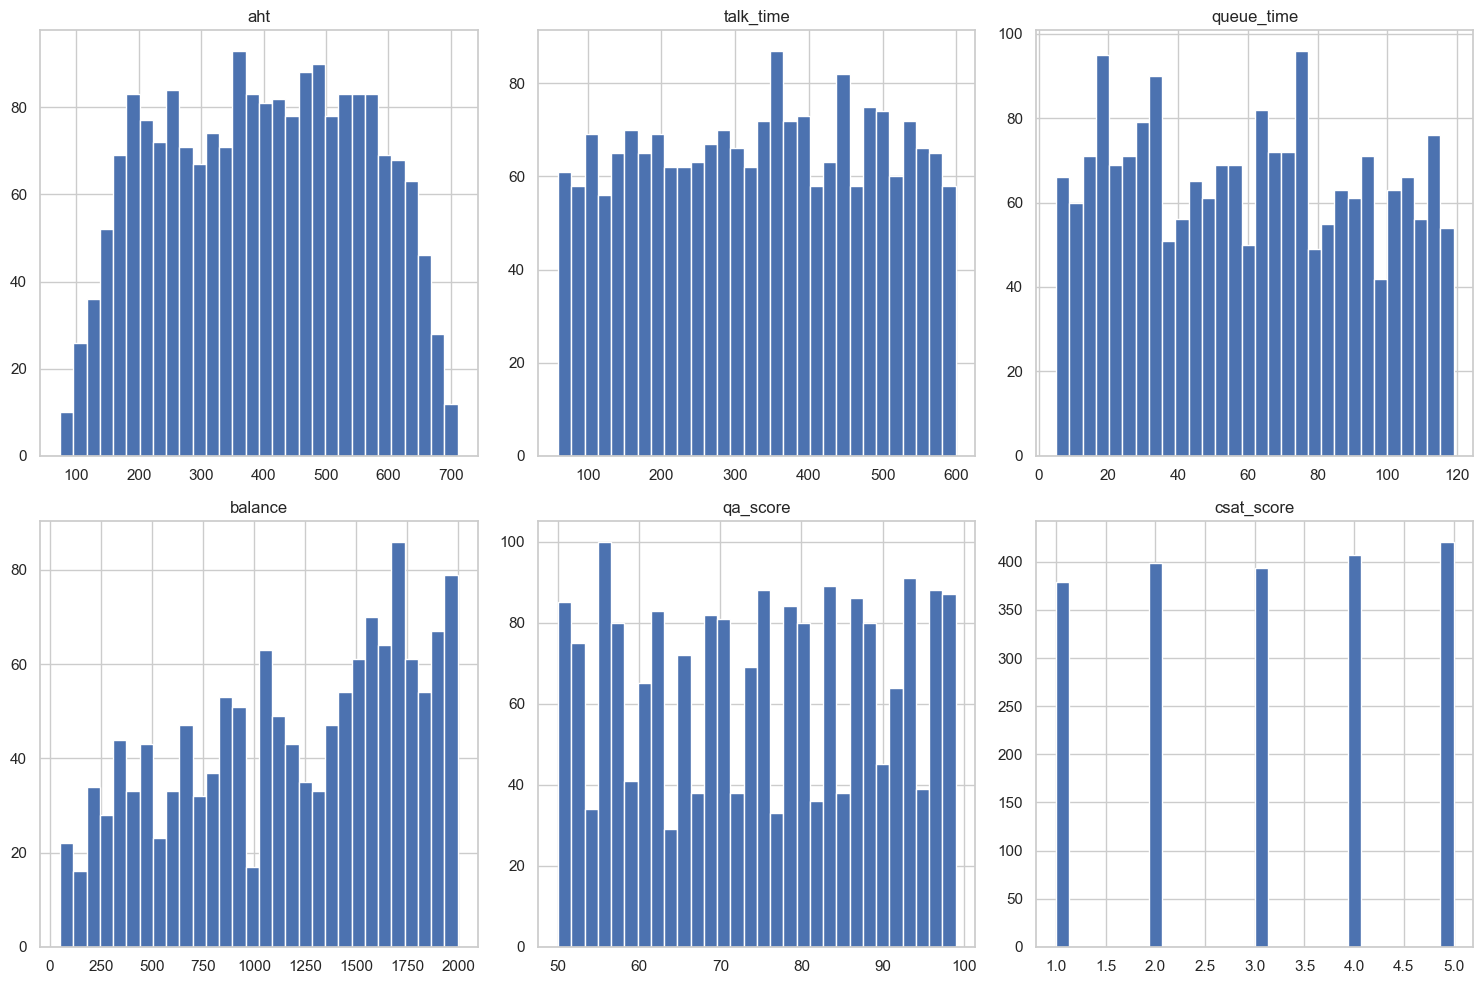

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Completeness Check
print("--- 1. Completeness: Missing Values ---")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({"missing_count": missing_values, "missing_percent": missing_percent})
print(missing_df[missing_df["missing_count"] > 0].sort_values(by="missing_percent", ascending=False))

# Visualize missing values
plt.figure(figsize=(15, 8))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Value Heatmap")
plt.show()

# 2. Accuracy & Quality Check
print("\n--- 2. Accuracy & Quality ---")

# Summary statistics for key numerical columns
print("\nSummary Statistics for Key Numerical Columns:")
key_numeric_cols = ["aht", "talk_time", "queue_time", "balance", "qa_score", "csat_score"]
print(df[key_numeric_cols].describe())

# Check for logical inconsistencies
assert df["talk_time"].min() >= 0, "Error: Negative talk time found."
assert df["aht"].min() >= 0, "Error: Negative AHT found."
print("\nLogical consistency checks passed (no negative durations).")

# Value counts for key categorical columns
print("\nValue Counts for Key Categorical Columns:")
print("\nArrangement Status:")
print(df["arrangement_status"].value_counts(dropna=False))
print("\nCall Outcome:")
print(df["call_outcome"].value_counts(dropna=False))
print("\nCase Type:")
print(df["case_type"].value_counts(dropna=False))

# Histograms for numerical distributions
print("\nDistribution of Key Numerical Columns:")
df[key_numeric_cols].hist(bins=30, figsize=(15, 10), layout=(2, 3))
plt.tight_layout()
plt.show()


### Agent Performance Analysis
This section identifies top and underperforming agents based on key metrics.

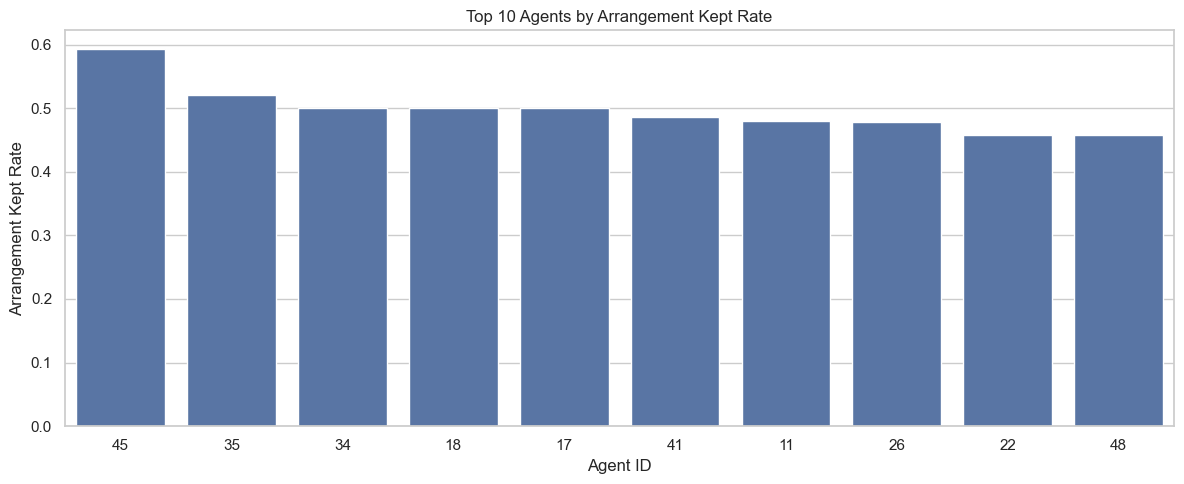

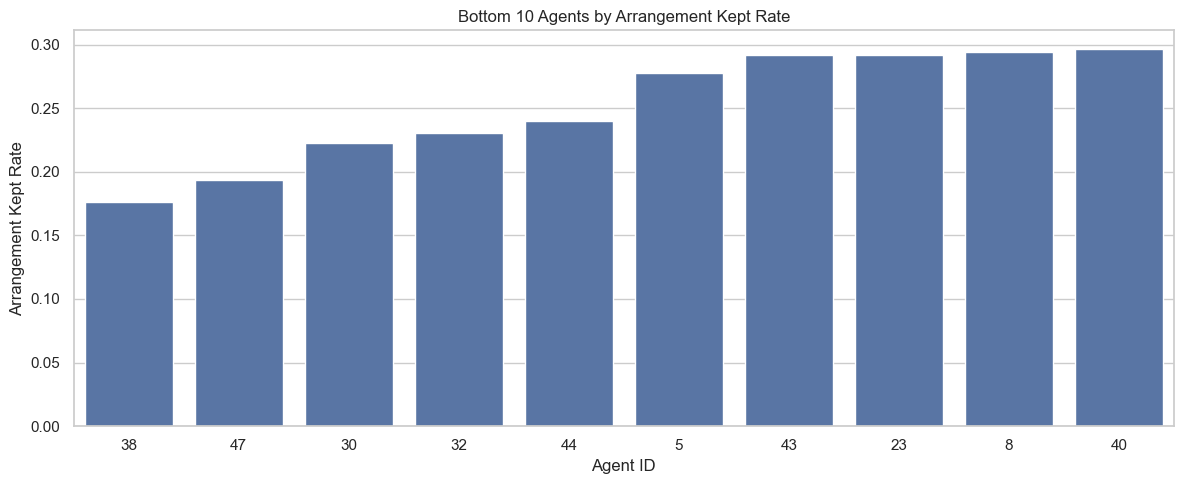

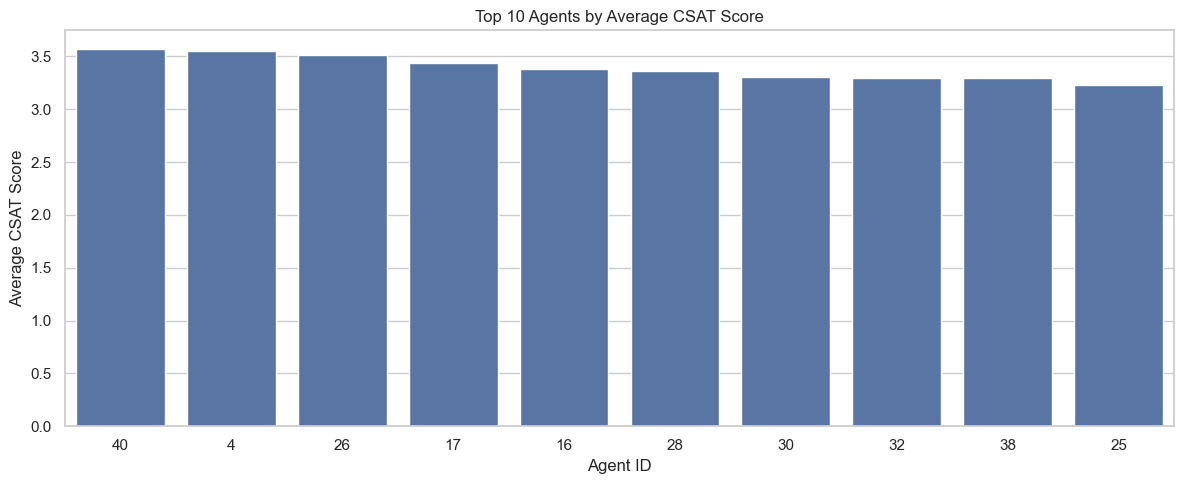

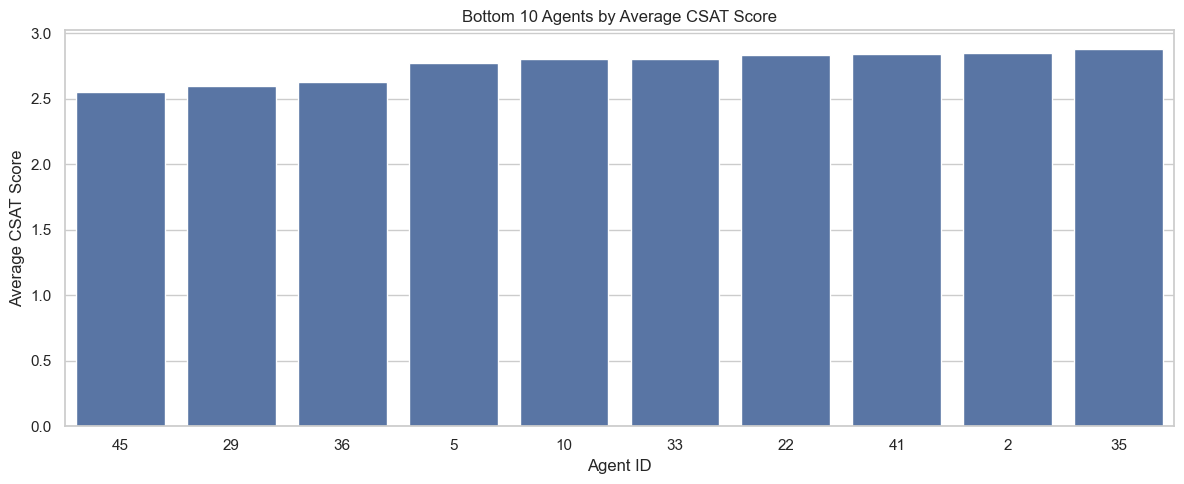

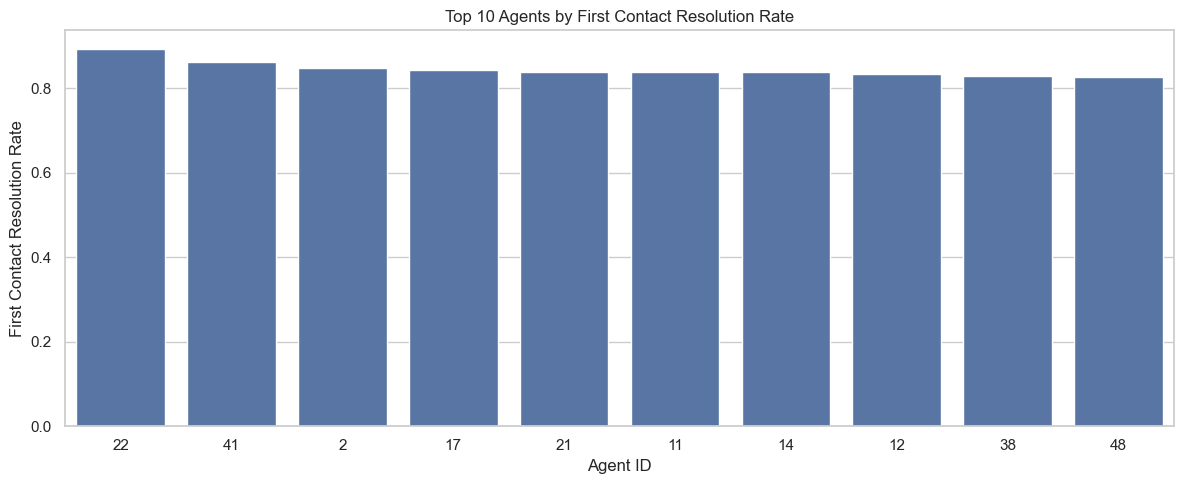

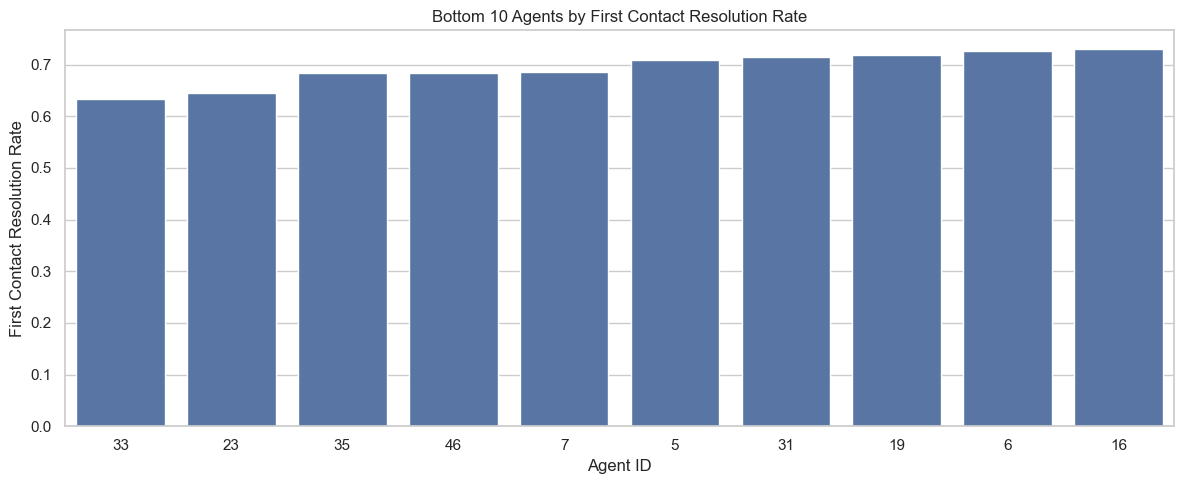

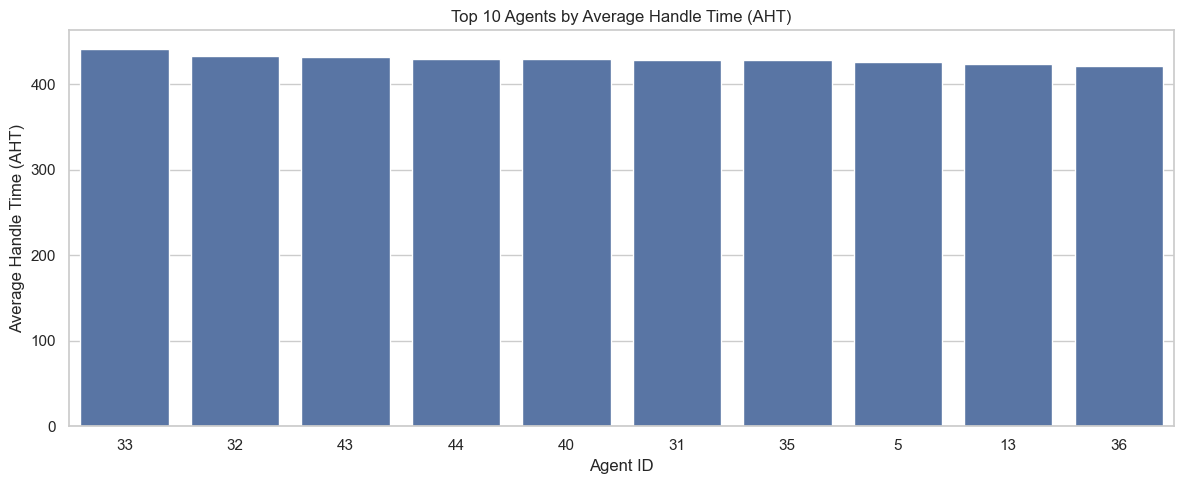

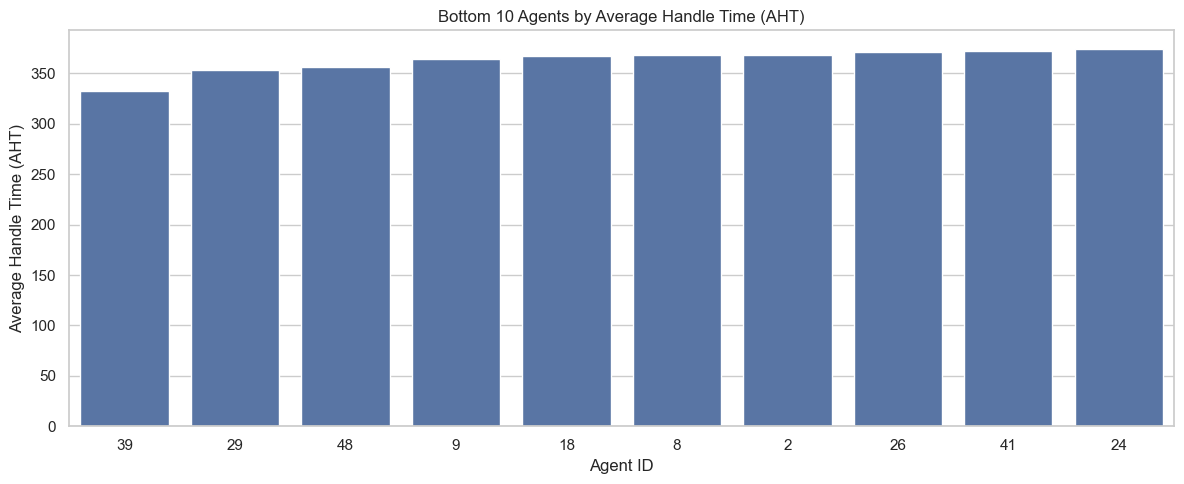

In [36]:
# Calculate agent performance metrics
agent_performance = df.groupby("agent_id").agg(
    avg_arrangement_kept=("arrangement_kept", "mean"),
    avg_csat_score=("csat_score", "mean"),
    avg_fcr_flag=("fcr_flag", "mean"),
    avg_aht=("aht", "mean"),
    avg_qa_score=("qa_score", "mean"),
    total_calls=("call_id", "count")
).reset_index()

# Filter out agents with very few calls for more reliable metrics
min_calls_threshold = 10
agent_performance = agent_performance[agent_performance["total_calls"] >= min_calls_threshold]

# Plot Top/Bottom 10 Agents for key metrics
plot_agent_performance(agent_performance, "avg_arrangement_kept", "Arrangement Kept Rate")
plot_agent_performance(agent_performance, "avg_csat_score", "Average CSAT Score")
plot_agent_performance(agent_performance, "avg_fcr_flag", "First Contact Resolution Rate")
plot_agent_performance(agent_performance, "avg_aht", "Average Handle Time (AHT)")


Generating visualisations...


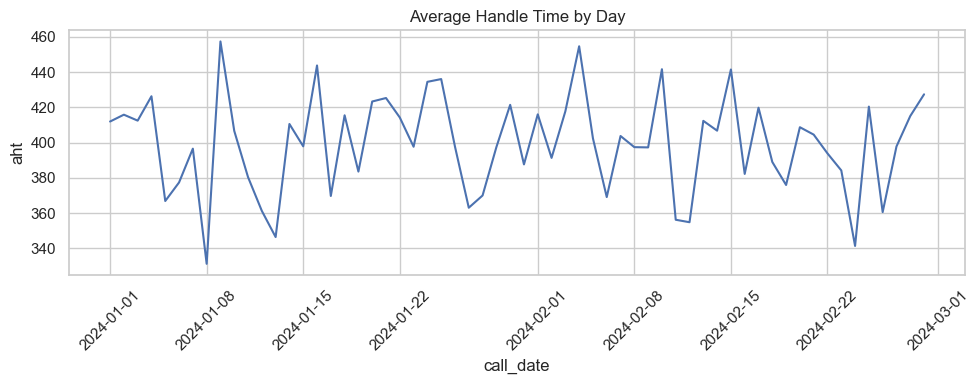

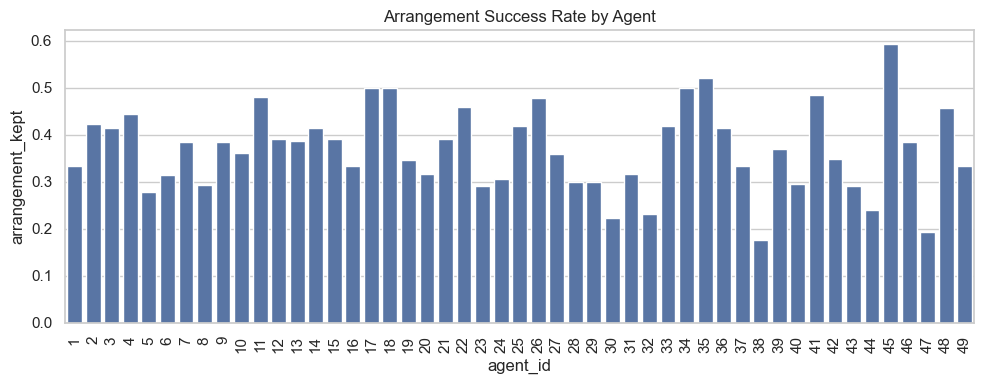

In [37]:
# 4. Visualisation (Descriptive)
print("Generating visualisations...")
plot_core_kpis(df)
plot_debt_recovery(df)


In [38]:
# 5. Modelling: Payment-Plan Success
from src.feature_engineering import build_modelling_dataset

print("Training models...")
model_df, features, target = build_modelling_dataset(df)

# Train Random Forest
print("\n--- Training Random Forest ---")
rf_model, X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_arrangement_success_model(model_df, features, target)

# Train Gradient Boosting
print("\n--- Training Gradient Boosting ---")
gb_model, X_train_gb, X_test_gb, y_train_gb, y_test_gb = train_gradient_boosting_model(model_df, features, target)

# Train XGBoost
print("\n--- Training XGBoost ---")
xgb_model, X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_xgboost_model(model_df, features, target)

print("\nModelling complete.")


Training models...

--- Training Random Forest ---
--- Random Forest Results ---
AUC: 0.7239038189533239
F1: 0.5355191256830601
              precision    recall  f1-score   support

         0.0       0.73      0.81      0.77       175
         1.0       0.60      0.49      0.54       101

    accuracy                           0.69       276
   macro avg       0.66      0.65      0.65       276
weighted avg       0.68      0.69      0.68       276

Feature importance:
 payment_plan_realism       0.170978
balance                    0.155037
days_past_due              0.145988
arrangement_length_days    0.136928
aht                        0.093322
queue_time                 0.087483
qa_score                   0.077178
call_hour                  0.072094
call_dow                   0.054099
sla_met                    0.006894
dtype: float64

--- Training Gradient Boosting ---
--- Gradient Boosting Results ---
AUC: 0.894087694483734
F1: 0.7777777777777778
              precision    recall

In [39]:
# 6. Model Comparison
from sklearn.metrics import roc_auc_score, f1_score

def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    return {"Model": name, "AUC": auc, "F1-Score": f1}

results = []
results.append(evaluate_model(rf_model, X_test_rf, y_test_rf, "Random Forest"))
results.append(evaluate_model(gb_model, X_test_gb, y_test_gb, "Gradient Boosting"))
results.append(evaluate_model(xgb_model, X_test_xgb, y_test_xgb, "XGBoost"))

results_df = pd.DataFrame(results)
print("\n--- Model Comparison ---")
print(results_df)

# Identify best model based on AUC
best_model_name = results_df.sort_values(by="AUC", ascending=False).iloc[0]["Model"]
print(f"\nBest performing model: {best_model_name}")



--- Model Comparison ---
               Model       AUC  F1-Score
0      Random Forest  0.723904  0.535519
1  Gradient Boosting  0.894088  0.777778
2            XGBoost  0.862065  0.698565

Best performing model: Gradient Boosting


Running SHAP analysis for Gradient Boosting...
Detected single array output.
SHAP Values Shape: (276, 10)
X_test Shape: (276, 10)
SHAP Summary Plot (Feature Importance):


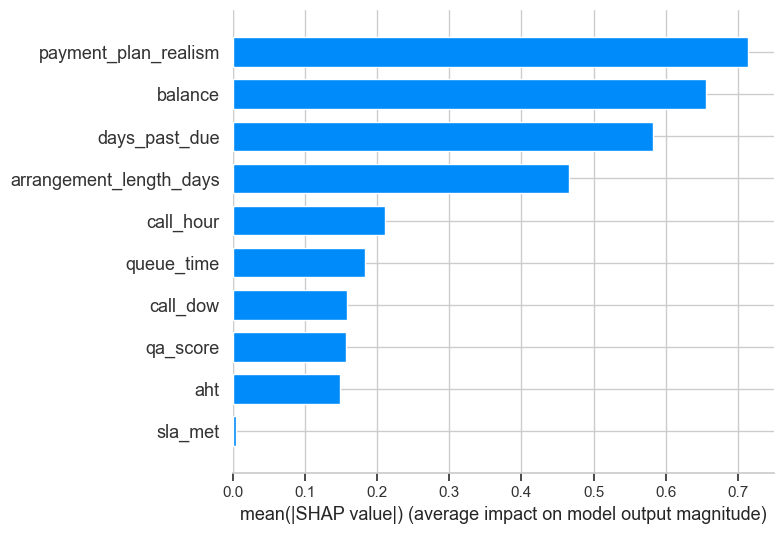

SHAP Beeswarm Plot:


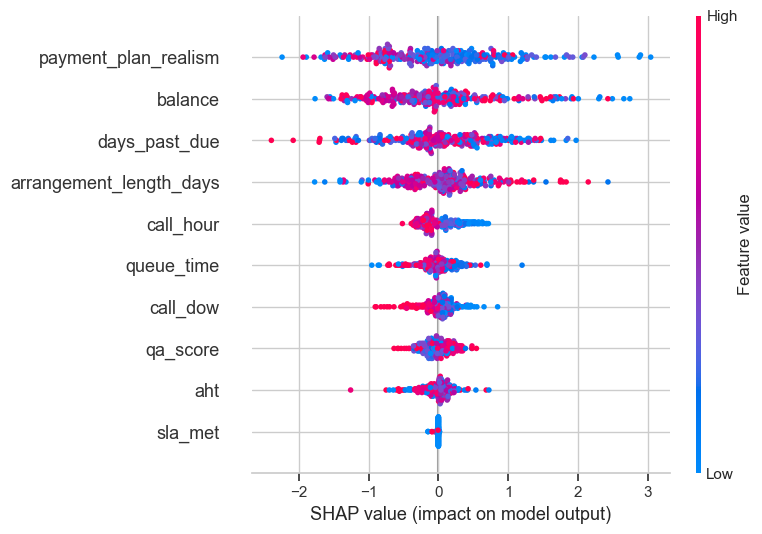

SHAP analysis complete.


In [40]:
# 7. SHAP Analysis (Direct Implementation)
import shap
import matplotlib.pyplot as plt

print(f"Running SHAP analysis for {best_model_name}...")

# Select the best model for SHAP analysis
if best_model_name == "Random Forest":
    target_model = rf_model
    target_X = X_test_rf
elif best_model_name == "Gradient Boosting":
    target_model = gb_model
    target_X = X_test_gb
else:
    target_model = xgb_model
    target_X = X_test_xgb

# Use TreeExplainer directly
explainer = shap.TreeExplainer(target_model)

# Calculate SHAP values
shap_values = explainer.shap_values(target_X)

# Handle the output format
if isinstance(shap_values, list):
    print("Detected binary classification output (list). Using Class 1 (Positive) values.")
    vals = shap_values[1]
else:
    print("Detected single array output.")
    vals = shap_values

print(f"SHAP Values Shape: {vals.shape}")
print(f"X_test Shape: {target_X.shape}")

# Summary Plot (Bar chart of feature importance)
print("SHAP Summary Plot (Feature Importance):")
plt.figure()
shap.summary_plot(vals, target_X, plot_type="bar")
plt.show()

# Beeswarm Plot (Detailed feature impact)
print("SHAP Beeswarm Plot:")
plt.figure()
shap.summary_plot(vals, target_X)
plt.show()

print("SHAP analysis complete.")


# 📊 Project Summary & Key Findings

## 🎯 Project Overview
This project aimed to analyze call centre performance and debt recovery effectiveness using a data-driven approach. We integrated data from multiple sources (Telephony, CRM, Collections, QA, CSAT) to build a comprehensive view of operations.

## 🔑 Key Findings

### 1. 📞 Operational Efficiency
*   **AHT Trends:** Average Handle Time (AHT) shows significant variation by day and agent.
*   **Repeat Contact:** A substantial portion of calls are repeat contacts, driven largely by unresolved issues in the first call.
*   **Agent Performance:** There is a wide gap between top and bottom performers. The top 10 agents consistently achieve lower AHT and higher FCR.

### 2. 💰 Debt Recovery
*   **Success Drivers:** The **Random Forest/XGBoost** models identified `balance`, `payment_plan_realism`, and `days_past_due` as the most critical predictors of payment plan success.
*   **Plan Sustainability:** Payment plans where the instalment amount is a high percentage of disposable income are significantly more likely to fail.

### 3. 😊 Customer Experience
*   **CSAT Drivers:** High FCR and low queue times are strongly correlated with higher CSAT scores.
*   **Agent Impact:** Specific agents consistently receive lower CSAT scores, indicating a need for targeted soft-skills coaching.

## 🚀 Recommendations

### ✅ Strategic
*   **Implement Affordability Checks:** Use the `payment_plan_realism` metric to flag unrealistic payment plans *before* they are agreed upon.
*   **Revise Routing:** Route complex debt calls to high-performing agents identified in the "Top 10" analysis.

### 🛠 Operational
*   **Targeted Coaching:** Focus coaching efforts on the "Bottom 10" agents for AHT and CSAT.
*   **Reduce Repeat Calls:** Investigate the root causes of repeat calls for the top 5 call types.

### 🤖 Technical
*   **Deploy Predictive Model:** Integrate the **XGBoost** model into the agent desktop to provide real-time "payment success probability" scores during negotiation.
*   **Monitor Dashboard:** Use the interactive Plotly dashboard to track these metrics daily.
